# Import necesarry modules 

In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Fisher_CMB import *
from Models.SPT3G.spt3G_model import spt3G_model
from Models.Planck.Planck_model import planck_model
import pickle as p
from Covariances.create_basic_cov import *
import pandas as pd
#import cosmoslik as K
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

# Define needed functions

In [3]:
def SPT3G_Fisher(params,fsky,saveas,
                 beam_width=array([0.00032*150/90,.00032,.00032*150/220]),
                 noise=[array([3.6,3.3,8.5]),'ukarc'],
                 lmin=50,
                 P_lmax=5000,
                 T_lmax=3000,
                 spectra=['TT','EE','TE']):
    '''Calculate a SPT3G bandpower covariance, fisher matrix, and save as pandas dataframe
    '''
    cov_params={}
    for k,v in params.items():
        if isinstance(v,fish_param):
            cov_params[k] = v.base
        else:
            cov_params[k]=v
    spt3g_cov=create_basic_cov(fsky,beam_width,noise,model='camb',specrange = (lmin,max([T_lmax,P_lmax])),
                               bin_size = 1,spectra=spectra,params=cov_params)
    full_spt3g_cov=make_full_cov(spectra,spt3g_cov)
    Fs,names=Fisher_Matrix(params,full_spt3g_cov,
                spt3G_model(model='camb',specrange = list(zip(spectra,[(lmin,T_lmax),(lmin,P_lmax),
                                                            (lmin,P_lmax)])),bin_size=1),show_results=True)
    pd.DataFrame(Fs,index=names,columns=names).to_hdf(saveas,'key')

In [4]:
def SPT3G_phi_Fisher(params,fsky,saveas,
                     lmin=50,lmax=3000):
    '''Calculate a SPT3G phiphi fisher matrix from previously made covariance
    '''
    cov_params={}
    for k,v in params.items():
        if isinstance(v,fish_param):
            cov_params[k] = v.base
        else:
            cov_params[k]=v
    m=spt3G_model(model='classy',specrange = [('PP',(lmin,lmax))],bin_size=10)
    spec = dot(m.windows['PP'],m.get_cmb_fgs_and_cals(cov_params)[0]['PP'][:lmax+1][m.windowrange['PP']])
    ell=dot(m.windows['PP'],arange(lmax+1)[m.windowrange['PP']])
    lensing_recon_cov_file = 'Covariances/spt3g_2.6uk_lmaxTT3000_lmaxPOL5000_nx1024_plikHM_TT_lowTEB_lensing.dat'
    lensing_err=dot(m.windows['PP'],loadtxt(lensing_recon_cov_file)[:,-1][m.windowrange['PP']])/(ell*(ell+1))
    lensing_recon_cov_file = 'Covariances/nlpp_ilc_res_SR_may2018_with_1_f_noise.pkl'
    lensing_err = p.load(open(lensing_recon_cov_file,'rb'),fix_imports=True,encoding='latin1')['NMV'][6:-1]/(ell*(ell+1))
    PP_cov=diag(lensing_err**2*(2.725*1e6)**4+(2/((2*ell+1)*fsky))*spec**2)/10
    Fs_phi,names=Fisher_Matrix(params,PP_cov,m,show_results=False)
    pd.DataFrame(Fs_phi,index=names,columns=names).to_hdf(saveas,'key')

In [5]:
lensing_recon_cov_file = 'Covariances/spt3g_2.6uk_lmaxTT3000_lmaxPOL5000_nx1024_plikHM_TT_lowTEB_lensing.dat'
err=loadtxt(lensing_recon_cov_file)[:,-1]
lle =loadtxt(lensing_recon_cov_file)[:,0]

In [6]:
lensing_recon_cov_file = 'Covariances/nlpp_ilc_res_SR_may2018_with_1_f_noise.pkl'
lensing_err = p.load(open(lensing_recon_cov_file,'rb'),fix_imports=True,encoding='latin1')['NMV']
ell = p.load(open(lensing_recon_cov_file,'rb'),fix_imports=True,encoding='latin1')['L']

<IPython.core.display.Javascript object>


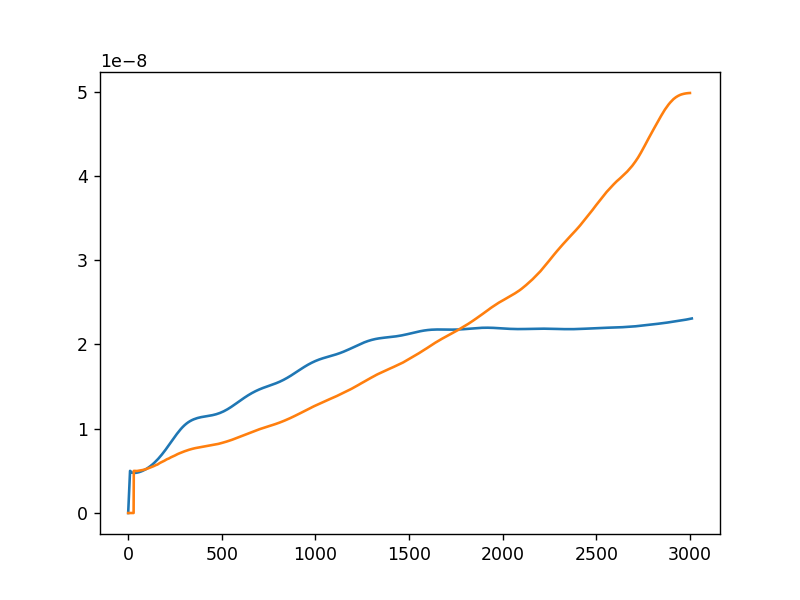

In [7]:
plot(ell,lensing_err)
plot(lle,err)
plt.show()

In [7]:
def Planck_800_Fisher(params,saveas):
    '''Calculate a planck lmin<800 bandpower covariance, fisher matrix, and save as pandas dataframe
    '''
    cov_params={}
    for k,v in params.items():
        if isinstance(v,fish_param):
            cov_params[k] = v.base
        else:
            cov_params[k]=v
    pcov_800=create_basic_cov(.7,[.0003],[0,'ukarc'],model='classy',specrange = (2,800),bin_size = 5,
                              spectra=['TT'],params=cov_params)
    full_pcov_800 = make_full_cov(['TT'],pcov_800)
    Fp_800,names=Fisher_Matrix(params,full_pcov_800,
                 planck_model(model='classy',specrange = [('TT',(2,800))],bin_size=5),show_results=False)
    pd.DataFrame(Fp_800,index=names,columns=names).to_hdf(saveas,'key')

In [8]:
def Planck_chain_Fisher(params,chain_path,saveas):
    '''Calculate a Planck Fisher matrix from a chain'''
    
    Planck_chain=K.chains.load_cosmomc_chain(chain_path).burnin(1000).join()
    Planck_chain=add_params(Planck_chain)
    cov_params=sorted(params)
    Planck_cov = Planck_chain.cov(cov_params)
    Fp=inv(Planck_cov)
    pd.DataFrame(Fp,index=cov_params,columns=cov_params).to_hdf(saveas,'key')

In [9]:
def SPTSZ_chain_Fisher(params,chain_path,saveas):
    '''Calculate a SPTSZ Fisher matrix from a chain'''
    
    SPTSZ_chain=K.load_chain(chain_path).burnin(500).join()
    SPTSZ_chain = slik2cmc(SPTSZ_chain)
    cov_params=sorted(params)
    SPTSZ_cov = SPTSZ_chain.cov(sorted(cov_params))
    Fsz=inv(SPTSZ_cov)
    pd.DataFrame(Fsz,index=cov_params,columns=cov_params).to_hdf(saveas,'key')

In [10]:
def add_params(planck):
    '''Add parameters to planck chain'''
    planck['ommh2']=planck['omegabh2']+planck['omegach2']
    planck['H0']=planck['H0*']
    planck['clamp']=planck['clamp*']
    planck['ombh2']=planck['omegabh2']
    planck['YHe']=planck.get('yhe',planck['H0*'])
    planck['omk']=planck.get('omegak',planck['H0*'])
    planck['cosmomc_theta']=planck['theta']/100
    return planck

In [11]:
def slik2cmc( c ):
    '''Convert slik params to names in use'''
    c['ns'] = c['cosmo.ns']
    c['ombh2'] = c['cosmo.ombh2']
    c['omch2'] = c['cosmo.omch2']
    c['tau'] = c['cosmo.tau']
    c['clamp'] = exp(c['cosmo.logA'])*exp(-2*c['tau'])/10
    c['ommh2']=c['ombh2']+c['omch2']
    c['H0'] = c['cosmo.H0']
    c['cosmomc_theta']=c['cosmo.theta']
    return c

# Make Fisher Matrices and Save 

##  LCDM Params

In [12]:
params_base={'H0':fish_param(67.90,0.55),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           'lmax':6000,
                           'tol_background_integration' : 1.e-3 ,
                            'tol_thermo_integration' : 1.e-3,
                            'tol_perturb_integration' : 1.e-6,
                            #'reionization_optical_depth_tol' : 1.e-5,
                            'l_logstep' : 1.08, 
                            'l_linstep' : 25,
                            'perturb_sampling_stepsize' : 0.04,
                            'delta_l_max' : 800,
                            'k_per_decade_for_pk': 10,
                            'k_per_decade_for_bao': 70,
                            'k_max_tau0_over_l_max': 6}

In [13]:
params3g_base={'H0':fish_param(67.90,0.55),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                            'Asz':fish_param(5.5,3,3,nuisance=True),
                            'Aps':fish_param(19.3,3.5,3.5,nuisance=True),
                            'Acib':fish_param(5,2.5,2.5,nuisance=True),
                            'A_TEps' : fish_param(.16,.05,nuisance=True),
                            'Pcal':fish_param(1.06,.01,.01,nuisance=True),
                           'lmax':6000,
                           'tol_background_integration' : 1.e-3 ,
                            'tol_thermo_integration' : 1.e-3,
                            'tol_perturb_integration' : 1.e-6,
                            #'reionization_optical_depth_tol' : 1.e-5,
                            'l_logstep' : 1.08, 
                            'l_linstep' : 25,
                            'perturb_sampling_stepsize' : 0.04,
                            'delta_l_max' : 800,
                            'k_per_decade_for_pk': 10,
                            'k_per_decade_for_bao': 70,
                            'k_max_tau0_over_l_max': 6}

In [16]:
def SPT3G_phi_Fisher(params,fsky,#saveas,
                     lmin=30,lmax=3000,binn=1):
    '''Calculate a SPT3G phiphi fisher matrix from previously made covariance
    '''
    cov_params={}
    for k,v in params.items():
        if isinstance(v,fish_param):
            cov_params[k] = v.base
        else:
            cov_params[k]=v
    m=spt3G_model(model='classy',specrange = [('PP',(lmin,lmax))],bin_size=binn)
    spec = m.get_cmb_fgs_and_cals(cov_params)[0]['PP'][:lmax+1]/(2.725*1e6)**2
    ell=arange(lmax+1)
    
    if fsky>.08:
        lensing_recon_cov_file = 'Covariances/spt3g_3.3uk_lmaxTT3000_lmaxPOL5000_nx1024_plikHM_TT_lowTEB_lensing.dat'
    else:
        lensing_recon_cov_file = 'Covariances/spt3g_2.6uk_lmaxTT3000_lmaxPOL5000_nx1024_plikHM_TT_lowTEB_lensing.dat'
    PP_cov=diag(dot(m.windows['PP'],
                ((2/((2*ell+1)*fsky))/(ell*.1)*(loadtxt(lensing_recon_cov_file)[:,-1]+spec)**2)[m.windowrange['PP']]))/binn
    
    L=dot(m.windows['PP'],ell[m.windowrange['PP']])
   
    errorbar(L,m(**cov_params)/(2.725*1e6)**2,yerr=sqrt(diag(PP_cov)),ecolor='g')
    xscale("log", nonposx='clip')
    yscale("log", nonposy='clip')
    xlim(30,3000)
    ylim(2e-10,2e-7)

/nfs/home/kmaylor/.virtualenvs/Forecasting_env/local/lib/python3.4/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/nfs/home/kmaylor/.virtualenvs/Forecasting_env/local/lib/python3.4/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>


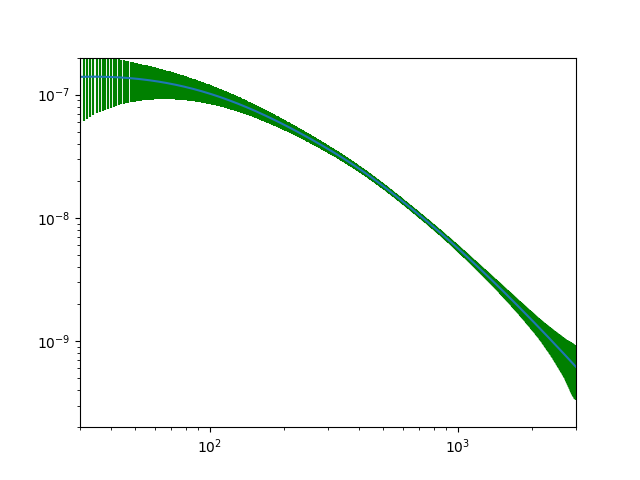

In [18]:
SPT3G_phi_Fisher(params_base,0.035,binn=1)

In [12]:
lmin=50
lmax=3000
cov_params={}
for k,v in params3g_base.items():
        if isinstance(v,fish_param):
            cov_params[k] = v.base
        else:
            cov_params[k]=v
m=spt3G_model(model='classy',specrange = [('PP',(lmin,lmax))],bin_size=1)
spec = m.get_cmb_fgs_and_cals(cov_params)[0]['PP'][:lmax+1]/(2.725*1e6)**2
ell=arange(lmax+1)
fsky=0.035

if fsky>.04:
    lensing_recon_cov_file = 'Covariances/spt3g_3.3uk_lmaxTT3000_lmaxPOL5000_nx1024_plikHM_TT_lowTEB_lensing.dat'
else:
    lensing_recon_cov_file = 'Covariances/spt3g_2.6uk_lmaxTT3000_lmaxPOL5000_nx1024_plikHM_TT_lowTEB_lensing.dat'
    PP_cov=diag(
                ((2/((2*ell+1)*fsky))*(loadtxt(lensing_recon_cov_file)[:,-1]+spec)**2))

In [13]:
with open('clphiphi_for_jason.txt', 'w') as f:
    for i,l in enumerate(ell):
        f.write(str(l)+' '+str(spec[i])+ ' '+str(sqrt(diag(PP_cov))[i]) + '\n')

<IPython.core.display.Javascript object>


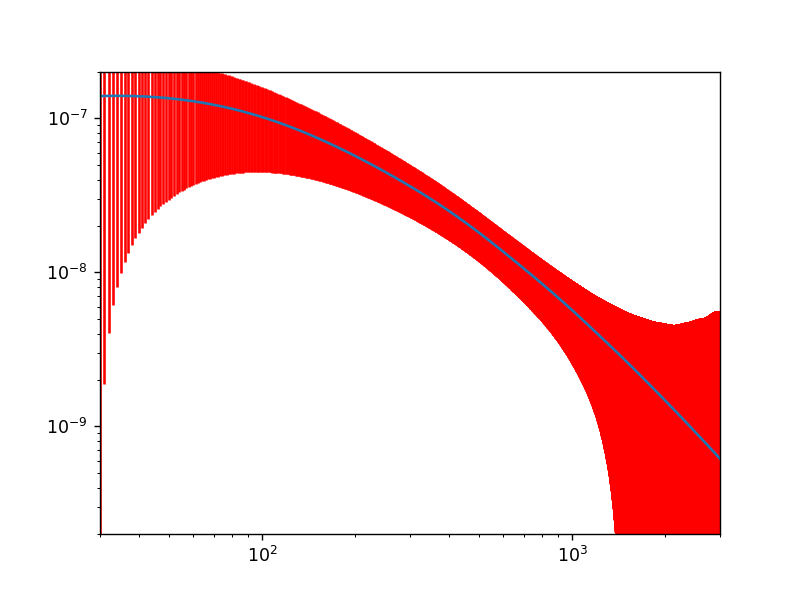

(2e-10, 2e-07)

In [14]:
errorbar(ell,spec,yerr=sqrt(diag(PP_cov)),ecolor='r')
xscale("log", nonposx='clip')
yscale("log", nonposy='clip')
xlim(30,3000)
ylim(2e-10,2e-7)

In [49]:
errorbar(ell[1:],spec[1:]/(ell[1:]*(ell[1:]+1)),yerr=sqrt(diag(PP_cov)[1:])/(ell[1:]*(ell[1:]+1)),ecolor='r')

<Container object of 3 artists>

<IPython.core.display.Javascript object>


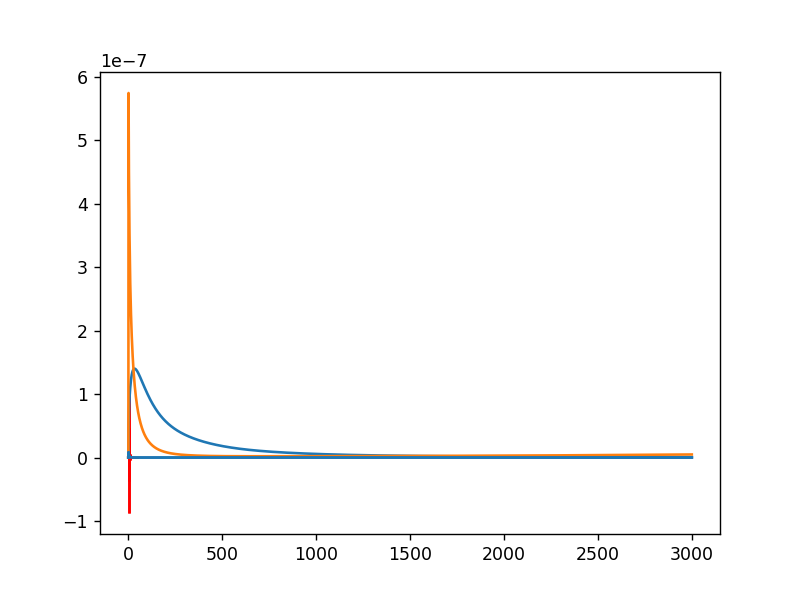

In [28]:
plot(spec)
plot(sqrt(diag(PP_cov)))

In [47]:
params3g_base_theta={'H0':None,'cosmomc_theta':fish_param(1.04087e-2,0.0050e-2*2),
                           'ombh2':fish_param(0.022260,0.0008*2),
                           #'ommh2':fish_param(0.1413,0.0011),
                      'omch2' : fish_param(0.1193,0.0030*2),
                           'tau':fish_param(0.063,0.020*2,.02),
                           #'clamp':fish_param(1.873,0.0115*2),
                            'As':fish_param(2.130e-9,0.1e-9*2),
                           'ns':fish_param(  0.9653,0.010*2),
                            'Asz':0,
                            'Aps':0,
                            'Acib':0,
                            'A_TEps' : 0,
                            'Pcal':1,
                           'lmax':2000,
                    }

### Extensions

In [13]:
model_extensions=[#('lcdm',{}),
#                   ('lcdm_neff',{'nnu':fish_param(3.046,0.03)}),
#                   ('lcdm_neff_yp',{'nnu':fish_param(3.046,0.03),
#                            'YHe':fish_param(.252,.014),}),
#                   ('lcdm_mnu',{'mnu':fish_param(.06,0.01)}),
#                   ('lcdm_omk',{'omk':fish_param(-0.003687,0.007)}),]
                   ('lcdm_dmdr',{'N_drf':fish_param(.1,0.01), 
                                 'Gamma0_dmdrf':fish_param(.4,0.04),
                                'gauge':'new'}),]
#                   ('lcdm_cdi',{'ic':'ad,cdi',
#                                'P_k_ini type':'two_scales',
#                                'k1':.002,
#                                'k2':.1,
#                                  'clamp':None,
#                                  'ns':None,
#                                'P_{RR}^1':fish_param(24e-10,5e-11),
#                                'P_{RR}^2':fish_param(21.5e-10,7.5e-11),
#                                'P_{II}^1':fish_param(1e-11,5e-12),
#                                'P_{II}^2':fish_param(10e-10,5e-10),
#                                'P_{RI}^1':fish_param(1e-11,1e-11),
#                                '|P_{RI}^2|':fish_param(1e-11,1e-11)}),
#                   ('lcdm_ndi',{'ic':'ad,nid',
#                                'P_k_ini type':'two_scales',
#                                'k1':.002,
#                                'k2':.1,
#                                  'clamp':None,
#                                  'ns':None,
#                                'P_{RR}^1':fish_param(24e-10,5e-11),
#                                'P_{RR}^2':fish_param(21e-10,5e-11),
#                                'P_{II}^1':fish_param(7.5e-11,5e-11),
#                                'P_{II}^2':fish_param(7.5e-10,3e-10),
#                                'P_{RI}^1':fish_param(-1e-13,1e-11),
#                                '|P_{RI}^2|':fish_param(2e-13,2e-13)}),
#                   ('lcdm_nvi',{'ic':'ad,niv',
#                                'P_k_ini type':'two_scales',
#                                'k1':.002,
#                                'k2':.1,
#                                'clamp':None,
#                                'ns':None,
#                                'P_{RR}^1':fish_param(24.75e-10,5e-11),
#                                'P_{RR}^2':fish_param(21.75e-10,5e-11),
#                                'P_{II}^1':fish_param(7.5e-11,5e-11),
#                                'P_{II}^2':fish_param(1e-10,5e-11),
#                                'P_{RI}^1':fish_param(-7.5e-11,5e-12),
#                                '|P_{RI}^2|':fish_param(7.5e-11,5e-12)}),]

### Planck TT $\ell$ < 800 Fisher matrix

In [15]:
for k in model_extensions:
    print(k[0])
    params=dict(params_base,**k[1])
    Planck_800_Fisher(params,'Saved_Fisher_Matrices/planck_TT_'+k[0]+'_800_Fisher_Matrix_theta.h5')

NameError: name 'model_extensions' is not defined

### SPT3G Fisher Matrix

In [18]:
SPT3G_Fisher(dict(params3g_base_theta,**{'mnu':fish_param(.06,0.02*2)}),1,'Saved_Fisher_Matrices/z_Fisher_Matrice.h5',
                 beam_width=array([0]),
                 noise=[array([0]),'ukarc'],
                 lmin=50,
                 P_lmax=2000,
                 T_lmax=2000,
                 spectra=['TT','EE','TE'])

/nfs/home/kmaylor/Forecasting/Covariances/create_basic_cov.py:37: RuntimeWarning: divide by zero encountered in true_divide
  con=lambda n:arcmin_per_sr/n**2


0 As 8.35261048549e-11
1 cosmomc_theta 2.21064722922e-06
2 mnu 0.378248228749
3 ns 0.00185122204316
4 ombh2 4.39455018502e-05
5 omch2 0.00056294367675
6 tau 0.0196181537249


In [15]:
for k in model_extensions:
    print(k[0])
    params=dict(params3g_base,**k[1])
    SPT3G_Fisher(params,0.06,'Saved_Fisher_Matrices/SPT3G_'+k[0]+'_lmin50_Fisher_Matrices_theta.h5')

lcdm_dmdr


### SPT3G Fisher Matrix fsky =0.035

###  SPT3G lensing reconstruction Fisher Matrix

In [16]:
for k in model_extensions:
    print(k[0])
    params=dict(params_base,**k[1])
    SPT3G_phi_Fisher(params,0.06,'Saved_Fisher_Matrices/SPT3G_phi_'+k[0]+'_lmin50_Fisher_Matrices_theta.h5')

lcdm_dmdr


### plikHM_TTTEEE_lowTEB Fisher Matrix

In [ ]:
planck_paths=['base/plikHM_TTTEEE_lowTEB/base_plikHM_TTTEEE_lowTEB',
             'base_nnu/plikHM_TTTEEE_lowTEB/base_nnu_plikHM_TTTEEE_lowTEB',
             'base_nnu_yhe/plikHM_TTTEEE_lowTEB/base_nnu_yhe_plikHM_TTTEEE_lowTEB',
             'base_mnu/plikHM_TTTEEE_lowTEB/base_mnu_plikHM_TTTEEE_lowTEB',
             'base_omegak/plikHM_TTTEEE_lowTEB/base_omegak_plikHM_TTTEEE_lowTEB']
for i,k in enumerate(model_extensions):
    if i in [0,1,2,3,4]:
        chain_path='/nfs/home/kmaylor/Official_Planck_chains/'+planck_paths[i]
        params=dict(params_base,**k[1])
        chain_params=[k for k,v in params.items() if isinstance(v,fish_param)]
        Planck_chain_Fisher(chain_params,chain_path,
                        'Saved_Fisher_Matrices/planck_TTTEEE_lowTEB'+k[0]+'_Fisher_Matrix_theta.h5')

### plikHM_TTTEEE_lowTEB_lensing Fisher Matrix

In [ ]:
planck_paths=['base/plikHM_TTTEEE_lowTEB_lensing/base_plikHM_TTTEEE_lowTEB_lensing',
             'base_nnu/plikHM_TTTEEE_lowTEB_nnu1_lensing/base_nnu_plikHM_TTTEEE_lowTEB_nnu1_lensing',
             'base_nnu_yhe/plikHM_TTTEEE_lowTEB_lensing/base_nnu_yhe_plikHM_TTTEEE_lowTEB_lensing',
             'base_mnu/plikHM_TTTEEE_lowTEB_lensing/base_mnu_plikHM_TTTEEE_lowTEB_lensing',
             'base_omegak/plikHM_TTTEEE_lowTEB_lensing/base_omegak_plikHM_TTTEEE_lowTEB_lensing']

for i,k in enumerate(model_extensions):
    if i in [0,3,4]:
        chain_path='/nfs/home/kmaylor/Official_Planck_chains/'+planck_paths[i]
        params=dict(params_base,**k[1])
        chain_params=[k for k,v in params.items() if isinstance(v,fish_param)]
        Planck_chain_Fisher(chain_params,chain_path,
                        'Saved_Fisher_Matrices/planck_TTTEEE_lowTEB_lensing'+k[0]+'_Fisher_Matrix_theta.h5')

### plikHM_TTTEEE_lowTEB_lensing_BAO Fisher Matrix

In [ ]:
planck_paths=['base/plikHM_TTTEEE_lowTEB_lensing_BAO/base_plikHM_TTTEEE_lowTEB_lensing_BAO',
             'base_nnu/plikHM_TTTEEE_lowTEB_nnu1_lensing_BAO/base_nnu_plikHM_TTTEEE_lowTEB_nnu1_lensing_BAO',
             'base_nnu_yhe/plikHM_TTTEEE_lowTEB_lensing_BAO/base_nnu_yhe_plikHM_TTTEEE_lowTEB_lensing_BAO',
             'base_mnu/plikHM_TTTEEE_lowTEB_lensing_BAO/base_mnu_plikHM_TTTEEE_lowTEB_lensing_BAO',
             'base_omegak/plikHM_TTTEEE_lowTEB_lensing_BAO/base_omegak_plikHM_TTTEEE_lowTEB_lensing_BAO']

for i,k in enumerate(model_extensions):
    if i in [3]:
        chain_path='/nfs/home/kmaylor/Official_Planck_chains/'+planck_paths[i]
        params=dict(params_base,**k[1])
        chain_params=[k for k,v in params.items() if isinstance(v,fish_param)]
        Planck_chain_Fisher(chain_params,chain_path,
                        'Saved_Fisher_Matrices/planck_TTTEEE_lowTEB_lensing_BAO'+k[0]+'_Fisher_Matrix_theta.h5')

### SPT-SZ Fisher Matrix

In [ ]:
chain_params=[k for k,v in params_base.items() if isinstance(v,fish_param)]

In [ ]:
chain_path="/home/kmaylor/Python_Projects/cosmology_chains/SPT_chainz_150x150.chains"
SPTSZ_chain_Fisher(chain_params,chain_path,'Saved_Fisher_Matrices/SPTSZ_lcdm_Fisher_Matrix_theta.h5')

# Load and Combine Planck and SPT FIsher Matrices

In [17]:
F={}
F=p.load(open('Saved_Fisher_Matrices\All_Planck_and_SPT3G_Fisher_matrices.p','rb'))
for i,k in enumerate(model_extensions):
    i=20
    f={}
    #SPT3G
    #f['SPT3G_fsky_0.035']=pd.read_hdf(
    #    'Saved_Fisher_Matrices/SPT3G_f035_'+k[0]+'_lmin50_Fisher_Matrices_theta.h5', 'key')
    f['SPT3G_fsky_0.06']=pd.read_hdf(
        'Saved_Fisher_Matrices/SPT3G_'+k[0]+'_lmin50_Fisher_Matrices_theta.h5', 'key')
    #SPT3G_clphiphi
    f['SPT3G_clphiphi_fsky_0.06']=pd.read_hdf(
        'Saved_Fisher_Matrices/SPT3G_phi_'+k[0]+'_lmin50_Fisher_Matrices_theta.h5', 'key')
    #f['SPT3G_clphiphi_fsky_0.035']=pd.read_hdf(
    #    'Saved_Fisher_Matrices/SPT3G_phi_f035_'+k[0]+'_lmin50_Fisher_Matrices_theta.h5', 'key')
    #SPT3G_lensing
    #f['SPT3G_lensing_fsky_0.035']=f['SPT3G_fsky_0.035'].add(f['SPT3G_clphiphi_fsky_0.035'])
    f['SPT3G_lensing_fsky_0.06']=f['SPT3G_fsky_0.06'].add(f['SPT3G_clphiphi_fsky_0.06'])
    #Planck_lmax800
    f['Planck_TT_lmax_800']=pd.read_hdf(
        'Saved_Fisher_Matrices/planck_TT_'+k[0]+'_800_Fisher_Matrix_theta.h5', 'key')
    #Planck_lmax800 and SPT3G
    #f['Planck_TT_lmax_800_SPT3G_fsky_0.035']=f['Planck_TT_lmax_800'].add(f['SPT3G_fsky_0.035'])
    f['Planck_TT_lmax_800_SPT3G_fsky_0.06']=f['Planck_TT_lmax_800'].add(f['SPT3G_fsky_0.06'])
    #f['Planck_TT_lmax_800_SPT3G_lensing_fsky_0.035']=f['Planck_TT_lmax_800_SPT3G_fsky_0.035'].add(
    #    f['SPT3G_clphiphi_fsky_0.035'])
    f['Planck_TT_lmax_800_SPT3G_lensing_fsky_0.06']=f['Planck_TT_lmax_800_SPT3G_fsky_0.06'].add(
        f['SPT3G_clphiphi_fsky_0.06'])
    if i in [0,1,2,3,4]:
        #Planck_TTTEEE_lowTEB
        f['Planck_TTTEEE_lowTEB']=pd.read_hdf(
            'Saved_Fisher_Matrices/planck_TTTEEE_lowTEB'+k[0]+'_Fisher_Matrix_theta.h5', 'key')
        #Planck_TTTEEE_lowTEB and SPT3G
     #   f['Planck_TTTEEE_lowTEB_SPT3G_fsky_0.035']=f['Planck_TTTEEE_lowTEB'].add(f['SPT3G_fsky_0.035'])
        f['Planck_TTTEEE_lowTEB_SPT3G_fsky_0.06']=f['Planck_TTTEEE_lowTEB'].add(f['SPT3G_fsky_0.06'])
      #  f['Planck_TTTEEE_lowTEB_SPT3G_lensing_fsky_0.035']=f['Planck_TTTEEE_lowTEB'].add(
       #     f['SPT3G_lensing_fsky_0.035'])
        f['Planck_TTTEEE_lowTEB_SPT3G_lensing_fsky_0.06']=f['Planck_TTTEEE_lowTEB'].add(
            f['SPT3G_lensing_fsky_0.06'])
    #Planck_TTTEEE_lowTEB_lensing and SPT3G_lensing
    if i in [0,3,4]:
        f['Planck_TTTEEE_lowTEB_lensing']=pd.read_hdf(
            'Saved_Fisher_Matrices/planck_TTTEEE_lowTEB_lensing'+k[0]+'_Fisher_Matrix_theta.h5', 'key')
        f['Planck_TTTEEE_lowTEB_lensing_SPT3G_lensing_fsky_0.06']=f['Planck_TTTEEE_lowTEB_lensing'].add(
            f['SPT3G_lensing_fsky_0.06'])
        f['Planck_TTTEEE_lowTEB_lensing_SPT3G_lensing_fsky_0.035']=f['Planck_TTTEEE_lowTEB_lensing'].add(
            f['SPT3G_lensing_fsky_0.035'])
        #Planck_TTTEEE_lowTEB_lensing_BAO and SPT3G_lensing
    if i in [3]:
        f['Planck_TTTEEE_lowTEB_lensing_BAO']=pd.read_hdf(
            'Saved_Fisher_Matrices/planck_TTTEEE_lowTEB_lensing_BAO'+k[0]+'_Fisher_Matrix_theta.h5', 'key')
        f['Planck_TTTEEE_lowTEB_lensing_BAO_SPT3G_lensing_fsky_0.06']=f['Planck_TTTEEE_lowTEB_lensing_BAO'].add(
            f['SPT3G_lensing_fsky_0.06'])
        f['Planck_TTTEEE_lowTEB_lensing_BAO_SPT3G_lensing_fsky_0.035']=f['Planck_TTTEEE_lowTEB_lensing_BAO'].add(
            f['SPT3G_lensing_fsky_0.035'])
        #SPTSZ
    if i ==0:
        f['SPTSZ']=pd.read_hdf('Saved_Fisher_Matrices/SPTSZ_lcdm_Fisher_Matrix_theta.h5', 'key')

    F[k[0]]=pd.concat(f).transpose()

In [18]:
p.dump(F,open('Saved_Fisher_Matrices\All_Planck_and_SPT3G_Fisher_matrices.p','wb'))

In [ ]:

F=p.load(open('Saved_Fisher_Matrices\All_Planck_and_SPT3G_Fisher_matrices.p','rb'))

In [ ]:
F